In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import *
import os
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# DATA_DIR_L =  ""
# DATA_DIR = DATA_DIR_L

DATA_DIR_M = "/home/masa/Downloads/google-cloud-sdk/our_data"
DATA_DIR = DATA_DIR_M

In [15]:
# We use spark session in order to use DataFrames
ss = SparkSession.builder \
    .appName("GoogleClusterAnalysis") \
    .master("local[2]") \
    .getOrCreate()

In [16]:
ss.sparkContext.setLogLevel("ERROR")

### 1. What is the distribution of the machines according to their CPU capacity? Can you explain (motivate) it?

In [17]:
machine_schema = StructType([
    StructField('timestamp', LongType(), True),
    StructField('machine_ID', LongType(), True),
    StructField('event_type', IntegerType(), True),
    StructField('platform_ID', StringType(), False),
    StructField('CPUs', DoubleType(), False),
    StructField('memory_capacity', DoubleType(), False),
    ])

In [18]:
df_machines = ss.read.csv(os.path.join(DATA_DIR,"machine_events/*.csv.gz"), schema=machine_schema)
df_machines.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [55]:
# First, we checked some information about the table, in order to get to know the data better

# Count distinct machines in df_machines
print(f'Distinct machines in df_machines: {df_machines.select('machine_ID').distinct().count()}')

# Count occuring event_types (according to documentation there are three (ADD(0), REMOVE(1), UPDATE(2))
print(f'Number of event_types: {df_machines.select("event_type").distinct().count()}')

# Count the occurance of event_type 0 (ADD)
print(f'Number of occurences of event_type 0: {df_machines.filter(df_machines["event_type"] == 0).distinct().count()}')

# Count the distinct number of event_type 0 (ADD) at timestamp 0 (when machines are started)
total_count_t0 = df_machines.filter(df_machines["timestamp"] == 0).distinct().count()
print(f'Number of event_type 0 at timestamp 0: {total_count_t0}')

# Count the distinct machines at timestamp 0 (varifying numbers)
print(f'Number of distinct machines at timestamp 0: {df_machines.select("machine_ID").filter(df_machines["timestamp"] == 0).distinct().count()}')

# Check if some machines have more than one CPU -> We conclude that only one CPUs value can be taken by one machine!
df_machines.groupBy("machine_ID").agg(F.count_distinct("CPUs").alias("distinct_cpus")).filter(F.col("distinct_cpus") > 1).show()

Distinct machines in df_machines: 12583
Number of event_types: 3
Number of occurences of event_type 0: 21443
Number of event_type 0 at timestamp 0: 12477
Number of distinct machines at timestamp 0: 12477
+----------+-------------+
|machine_ID|distinct_cpus|
+----------+-------------+
+----------+-------------+



In [56]:
# Display the type of CPUs machines are using at timestamp 0
df_machines.select("CPUs").filter(df_machines["timestamp"] == 0).distinct().toPandas()

,CPUs
0,1.00
1,0.50
2,0.25


In [57]:
# Now, we count how many machines have each CPU count at timestamp 0
df_cpu_count = df_machines.select(['machine_ID', 'CPUs']).filter(df_machines["timestamp"] == 0).groupby('CPUs').count()
df_cpu_count.toPandas()

,CPUs,count
0,1.00,791
1,0.50,11563
2,0.25,123


In [58]:
# Finally, we calculate percentage of count
df_cpu_count.withColumn("percentage", F.round((F.col("count") / total_count_t0) * 100)).toPandas()

,CPUs,count,percentage
0,1.00,791,6.0
1,0.50,11563,93.0
2,0.25,123,1.0


<Figure size 1000x400 with 0 Axes>

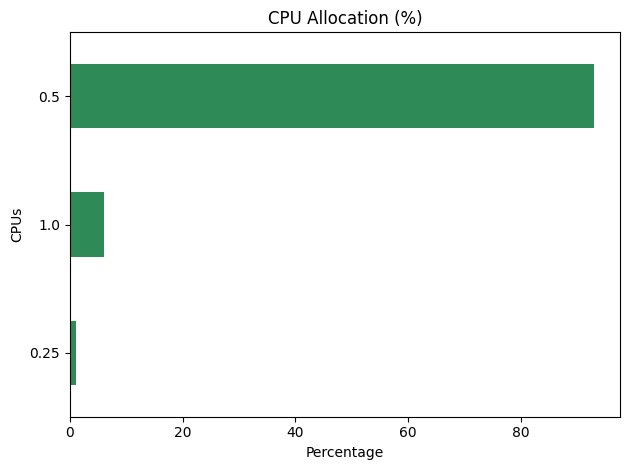

In [59]:
# Visualization
df_cpu_per = df_cpu_count.withColumn("percentage", F.round((F.col("count") / total_count_t0) * 100)).toPandas()

plt.figure(figsize=(10, 4))
ax = df_cpu_per.sort_values('percentage').plot(
    kind='barh', 
    x='CPUs', 
    y='percentage', 
    color='seagreen', 
    legend=False
)

plt.title('CPU Allocation (%)')
plt.xlabel('Percentage')
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('images/task1.png', dpi=300)

**Conclusion:** At timestamp "0" there are 12,477 machines initially started. The CPU capacity of the machines can be grouped into three types of capacity volumes (0.25, 0.5 and 1). 1% of the machines use 0.25 CPUs, 6% 1.0 CPUs and 93% were using 0.5 CPUs when initally started. According to the documentation, these capacities are normalised, and it states that "The normalization is a scaling relative to the largest capacity of the resource on any machine in the trace (which is 1.0)."

One reason for the majority of CPUs being at 0.5 capacity could be that it is easier to maintain the machines if they all have a similar hardware meaning a similar CPU, e.g. to have fewer types of spare CPU in stock. Having a "standard" CPU will also reduce the complexity of scheduling jobs and tasks, as the machines are fairly homogenous and tasks can be scheduled without much computation.

### 2. What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)? The computational power is proportional to both the CPU capacity and the unavailability period of machines.

The documentation states that, "event_type = 1" means that a machine was removed from the cluster. Removals can occur due to
failures or maintenance. Therefore, we want to find all the times a machine was removed and then reconnected later (event_type = 0 in a time step after the event_type = 1).

In [60]:
from pyspark.sql import Window

In [61]:
# By partitioning the window by machine_id, we ensure that all events types are processed independently for each machine. 
# In that way, we are sure that event pairings will refer to the same physical machine.
window = Window.partitionBy("machine_ID").orderBy("timestamp")


# The lead() function returns the following event and time for the same machine. Previously, we ordered events by timestamp, 
# and therefore, "next" refers to the next chronological event in that machine's sequence of events. In that way, we can be 
# sure that we are identifying distinct offline intervals without overlappings.
df_next = df_machines.withColumn("next_event_type", F.lead("event_type").over(window))
df_next = df_next.withColumn("next_time", F.lead("timestamp").over(window))

df_next.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,next_time
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,1.0,8.351507e+11
1,835150655707,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0.0,8.361249e+11
2,836124903464,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN
3,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN
4,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN


In [64]:
# Now, we want to filter df_next to reflect only situations when machine went offline and was reloaded afterwards. 
# That can be achieved by observing event_type=1 followed by next_event=0

df_reloaded = df_next.filter((df_next["event_type"]==1) & (df_next["next_event_type"]==0))
df_reloaded.count()

8860

We notice that this number matches the number of such observed cases of reloaded machines that were mentioned in paper: https://www.researchgate.net/publication/261164671_Characterizing_Machines_and_Workloads_on_a_Google_Cluster  on page 3 (Figure 3) which tells us we're on good trace.

In [65]:
# Here we just extract offline time in a column named "offline_time"
df_reloaded = df_reloaded.withColumn("offline_time", F.col("next_time").cast("long")-F.col("timestamp").cast("long")).drop("timestamp", "next_time")
df_reloaded.limit(5).toPandas()

,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,offline_time
0,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,974247757
1,10,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,998726348
2,13,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,997280215
3,23,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,120851153
4,26,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,88666880740


In [67]:
# Now we calculate lost resources for each sample as a product of offline time and CPUs, and then we sum over all samples
df_reloaded = df_reloaded.withColumn("power_lost", df_reloaded["offline_time"]*df_reloaded["CPUs"])
total_power_lost = df_reloaded.agg(F.sum("power_lost")).collect()[0][0]

df_reloaded.limit(3).toPandas()

,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,offline_time,power_lost
0,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,974247757,487123878.5
1,10,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,998726348,499363174.0
2,13,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,997280215,498640107.5


Now, in order to compute the percentage of lost resources, we estimate the total available computational power. For this purpose, we group events by machine and assume a constant CPU capacity per machine. For each machine, we compute its lifetime as the time between the first and last recorded event. The total computational power is then obtained by multiplying the machine lifetime by its CPU capacity and summing this quantity over all machines.

In [68]:
df_machine_lifetime = df_machines.groupBy("machine_ID", "CPUs").agg((F.max("timestamp") - F.min("timestamp")).alias("lifetime"))
df_machine_lifetime = df_machine_lifetime.withColumn("total_power", F.col("lifetime") * F.col("CPUs"))

total_power = df_machine_lifetime.agg(F.sum("total_power").alias("total")).collect()[0]["total"]

In [69]:
percentage_lost = total_power_lost/total_power * 100
print(f"Percentage of computational power lost: {percentage_lost:.4f}%")

Percentage of computational power lost: 1.8879%


**Conclusion:** Over all machines and for the whole covered period, we conclude that the total percentage of computational power lost due to mainenance (and failures) is 1.8879%.

## 3. Is there a class of machines, according to their CPU, that stands out with a higher maintenance rate, as compared to other classes ?

Here, by maintenance rate, we observe how frequently machines undergo maintenance (or else: offline periods). We want to see if there is a class of machines (grouped by their CPU capacity) that experiences longer or more frequent maintenance periods compared to others. 

We calculate maintenance rate as a total_offline_time per machine divided by total_time (already calculated in previous task). We will use already calculated df_reloaded from previous task

In [82]:
# Check df from task 2
df_reloaded.limit(3).toPandas()

,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,offline_time,power_lost
0,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,974247757,487123878.5
1,10,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,998726348,499363174.0
2,13,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,997280215,498640107.5


In [83]:
df_reloaded.count()

8860

In [84]:
# Here, we calculate each machine's lifetime from its first appearance to its last recorded action, in a separate column
df_machine_lifetime = df_machines.groupBy("machine_ID", "CPUs").agg((F.max("timestamp") - F.min("timestamp")).alias("lifetime"))
df_machine_lifetime = df_machine_lifetime.filter(F.col("lifetime")>0)
df_machine_lifetime.limit(3).toPandas()

,machine_ID,CPUs,lifetime
0,660798,0.5,1667636629875
1,903434,0.5,752077826190
2,1095222,0.5,520407670149


In [85]:
# In this table, we store total offline time of each machine
df_offline_times = df_reloaded.groupBy("machine_ID", "CPUs").agg(F.sum("offline_time").alias("total_offline_time"))
df_offline_times.limit(3).toPandas()

,machine_ID,CPUs,total_offline_time
0,5,0.5,974247757
1,10,0.5,998726348
2,13,0.5,997280215


In [86]:
# Now, we join lifetime and downtime data to find the percentage of time each CPU category spends in maintenance, 
# by dividing the total time machines were offline by their total lifetime for each CPU group
df_machine_times = df_machine_lifetime.join(df_offline_times, ["machine_ID", "CPUs"])

df_maintenance = df_machine_times.groupBy("CPUs").agg(
    (F.sum("total_offline_time") / F.sum("lifetime") * 100).alias("percent_maintenance_rate"),
    F.count("*").alias("n_machines")
)

df_maintenance.limit(3).toPandas()

,CPUs,percent_maintenance_rate,n_machines
0,1.00,1.427183,326
1,0.50,2.040785,4700
2,0.25,3.246884,71


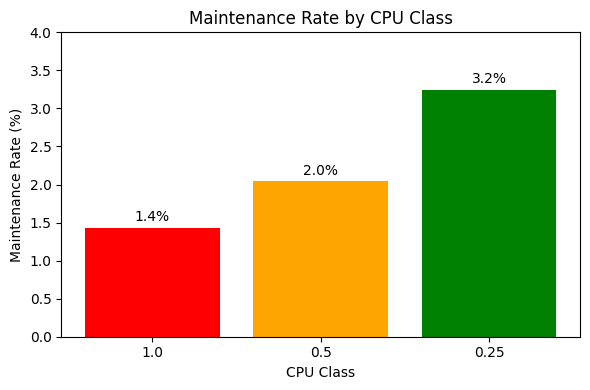

In [91]:
# Visualization
df_plot = df_maintenance.select('CPUs', 'percent_maintenance_rate').toPandas()

cpus_list = df_plot['CPUs'].astype(str).tolist()
rates_list = df_plot['percent_maintenance_rate'].tolist()

plt.figure(figsize=(6, 4))
bars = plt.bar(cpus_list, rates_list, color=['red', 'orange', 'green'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}%', ha='center', va='bottom')

plt.xlabel('CPU Class')
plt.ylabel('Maintenance Rate (%)')
plt.title('Maintenance Rate by CPU Class')
plt.tight_layout()
plt.ylim(0, 4)
plt.savefig('images/task3.png', dpi=300, bbox_inches='tight')

**Conclusion:** lower CPU capacity correlates with higher maintenance rates. The maintenance rate decreases as CPU capacity increases, suggesting a consistent relationship between resource allocation and maintenance needs. This pattern could indicate that machines with less resources (less CPUs) experience failures more frequently, and that means they require more maintenance.

### 4. What is the distribution of the number of jobs/tasks per scheduling class? Comment on the results.

In [92]:
# Define schema for job events table
job_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("job_name", StringType(), True),
    StructField("logical_job_name", StringType(), True)
])

In [93]:
df_job_events = ss.read.csv(os.path.join(DATA_DIR,"job_events/*.csv.gz"), schema=job_events_schema)
df_job_events.limit(5).toPandas()

,timestamp,missing_info,job_id,event_type,user_name,scheduling_class,job_name,logical_job_name
0,772325004610,None,6319958772,1,ZpQmujQYX55FcN2RFvqqUkcz5z/Tovj2FaG8sFtlG48=,0,4iFTcCfph6IhTG3o4wYegeDbshbOLsVmej89GFCe+bo=,AmKr63lD9MIGXiAacmzoj6kQMGqk2U0M89A2RkgB6uc=
1,772325045338,None,6319984350,0,E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,1,UaXnrc6huaDo9qNtX9ukOIn8h7t8fOT2Ovcv9+GSsKQ=,Mz+7hmVdCFVQEwwuv/CoVxcc2YEG/CPiY4GZi3YyLKE=
2,772325074372,None,6319983180,0,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,2,ct6ai8SyqLEEEdgBSqx9Pw5iuhMahN3L81jZKfFedD4=,G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=
3,772326178083,None,6319984385,0,F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=,0,aPxb6dFdH8wZ2FTBCDuRFDFmTkCuuAJHXUSj1woB7C0=,j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=
4,772327671789,None,6319983180,1,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,2,ct6ai8SyqLEEEdgBSqx9Pw5iuhMahN3L81jZKfFedD4=,G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=


In [94]:
# define schema for task events table
task_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("req_cpu_cores", DoubleType(), True),
    StructField("req_ram", DoubleType(), True),
    StructField("req_local_disk", DoubleType(), True),
    StructField("different_machine_constraint", BooleanType(), True)
])

In [95]:
df_task_events = ss.read.csv(os.path.join(DATA_DIR,"task_events/*.csv.gz"), schema=task_events_schema)
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


#### Number of Jobs per scheduling class

In [96]:
# Count number of unique jobs per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in each group
jobs_per_class = df_job_events.select("job_id", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("job_id").alias("num_of_jobs"))

jobs_per_class.toPandas()

,scheduling_class,num_of_jobs
0,1,2977
1,3,110
2,2,2525
3,0,3158


In [97]:
# Calculate total number of unique jobs in the dataset
# counts distinct job_ids across all events to get the absolute total
total_jobs_job_events = df_job_events.select("job_id").distinct().count()
total_jobs_job_events

8770

In [98]:
# verify total_jobs for job_events
2977 + 110 + 2525 + 3158

8770

In [99]:
# Calculate total number of unique jobs in the dataset
# counts distinct job_ids across all events to get the absolute total
total_jobs_task_events = df_task_events.select("job_id").distinct().count()
total_jobs_task_events

9642

As the documentation explains, monitoring data is collected periodically, and when the system gets overloaded, data may not be collected. Job events might be missed while task events are still captured. So we are going to use df_task_events for the complete count of jobs that actually ran tasks.

In [100]:
# Count number of unique jobs per scheduling class in df_task_events
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in combination with task_index in each group
jobs_per_class_taskev = df_task_events.select("job_id", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("*").alias("num_of_jobs"))

jobs_per_class_taskev.toPandas()

,scheduling_class,num_of_jobs
0,1,3141
1,3,367
2,2,2783
3,0,3351


In [101]:
# verify total_jobs for task_events
3141 + 367 + 2783 + 3351

9642

In [102]:
jobs_per_class_taskev = jobs_per_class.withColumn("job_percentage", F.round((F.col("num_of_jobs") / total_jobs_task_events) * 100))
jobs_per_class_taskev.toPandas()

,scheduling_class,num_of_jobs,job_percentage
0,1,2977,31.0
1,3,110,1.0
2,2,2525,26.0
3,0,3158,33.0


#### Number of tasks per scheduling class

In [103]:
# Count number of unique tasks per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in combination with task_index in each group
tasks_per_class = df_task_events.select("job_id", "task_index", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("*").alias("num_of_tasks"))

tasks_per_class.toPandas()

,scheduling_class,num_of_tasks
0,1,32864
1,3,2590
2,2,9607
3,0,285756


In [104]:
# Calculate total number of unique jobs in the dataset
# counts distinct combination of job_ids and task_index across all events to get the absolute total
total_tasks = df_task_events.select("job_id", "task_index").distinct().count()
total_tasks

330817

In [105]:
tasks_per_class_df = tasks_per_class.withColumn("task_percentage", F.round((F.col("num_of_tasks") / total_tasks) * 100))
tasks_per_class_df.toPandas()

,scheduling_class,num_of_tasks,task_percentage
0,1,32864,10.0
1,3,2590,1.0
2,2,9607,3.0
3,0,285756,86.0


In [106]:
# Result joined dataframe
result = jobs_per_class_taskev.join(tasks_per_class_df, "scheduling_class", "inner")
result.toPandas()

,scheduling_class,num_of_jobs,job_percentage,num_of_tasks,task_percentage
0,1,2977,31.0,32864,10.0
1,3,110,1.0,2590,1.0
2,2,2525,26.0,9607,3.0
3,0,3158,33.0,285756,86.0


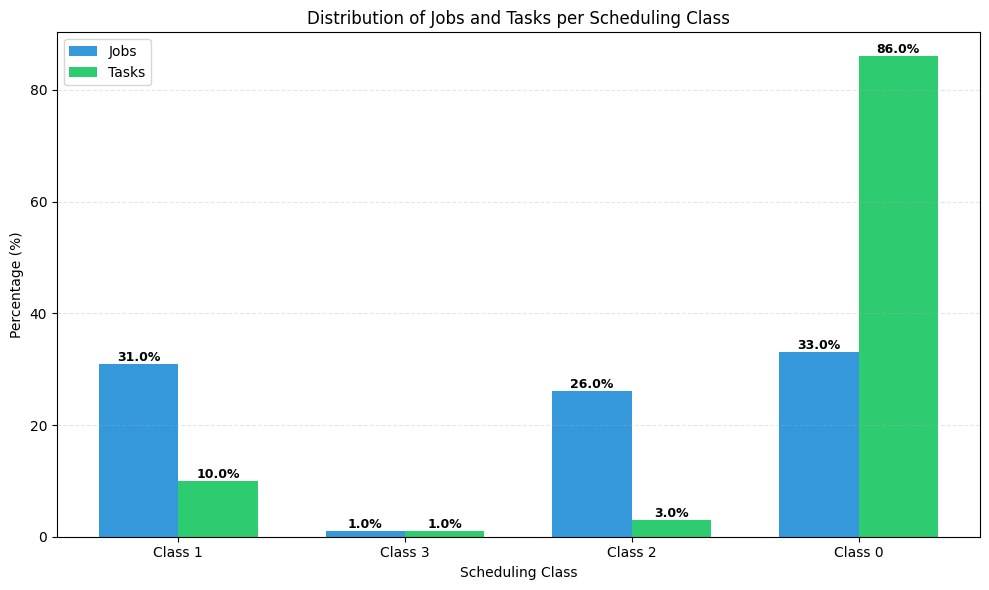

In [107]:
# Visualisation

result = result.toPandas() 

scheduling_classes = ['Class ' + str(int(x)) for x in result['scheduling_class']]
job_percentages = result['job_percentage'].tolist()
task_percentages = result['task_percentage'].tolist()

# Create chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = scheduling_classes
x_pos = [0, 1, 2, 3]
width = 0.35

bars1 = ax.bar([p - width/2 for p in x_pos], job_percentages, width, label='Jobs', color='#3498db')
bars2 = ax.bar([p + width/2 for p in x_pos], task_percentages, width, label='Tasks', color='#2ecc71')

# labels and title
ax.set_xlabel('Scheduling Class')
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of Jobs and Tasks per Scheduling Class')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

# percentage labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{job_percentages[i]}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{task_percentages[i]}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()
fig.savefig('images/task4.png', bbox_inches='tight', dpi=300)

The analysis is based on the task events table (df_task_events), which was chosen because it provides a complete view of all 9,642 jobs in the dataset, as opposed to the job events table which only contains 8,770 jobs due to missing records from data collection issues. 

As the documentation points out, class 0 define non-production workloads. Those make up the most jobs (33%) and the most tasks (86%). This also suggests that non-production jobs tend to have many task per jobs. In contrast, class 1 compromises 31% of all jobs but only 10% of tasks, indicating that those are smaller jobs. Class 2 shows a similar pattern with 26% for jobs and 3% for tasks. Finally, class 3, which - according to the documentation - represent the latency sensitive production workloads make up only 1% of all jobs as well as only 1% of all tasks. 

The results show that higher scheduling classes tend to have fewer tasks per job, while lower classes run larger parallel workloads. 

### 5. Would you qualify the percentage of jobs/tasks that got killed or evicted as important? 
Again, we are going to use df_task_events as our data base

In [108]:
# Define event type constants for readability
EVICT = 2
KILL = 5

# Count unique jobs that were killed or evicted at least once across its lifecycle
jobs_killed_evicted = df_task_events.filter(F.col("event_type").isin([EVICT, KILL])).select("job_id").distinct().count()
jobs_killed_evicted

4915

In [109]:
# Calculate percentage (using the total_jobs_task_events from question 4)
perc_jobs_killed_evicted = round(jobs_killed_evicted / total_jobs_task_events * 100)
perc_jobs_killed_evicted

51

In [110]:
# Break down by event type "KILL"
jobs_killed = df_task_events.filter(F.col("event_type") == KILL).select("job_id").count()
jobs_killed

138951

In [111]:
# Break down by event type "EVICT"
jobs_evicted = df_task_events.filter(F.col("event_type") == EVICT).select("job_id").count()
jobs_evicted

83227

In [112]:
# Calculate individual percentages for jobs
perc_jobs_killed = round(df_task_events.filter(F.col("event_type") == KILL).select("job_id").distinct().count() / total_jobs_task_events * 100, 1)
perc_jobs_evicted = round(df_task_events.filter(F.col("event_type") == EVICT).select("job_id").distinct().count() / total_jobs_task_events * 100, 1)

In [113]:
perc_jobs_killed

45.1

In [114]:
perc_jobs_evicted

10.0

In [115]:
# Count unique tasks that were killed or evicted at least once across its lifecycle
tasks_killed_evicted = df_task_events.filter(F.col("event_type").isin([EVICT, KILL])).select("task_index", "job_id").distinct().count()
tasks_killed_evicted

141832

In [116]:
# Calculate percentage (using total_task from question 4 = all tasks with a distinct combination of job_ids and task_index)
perc_tasks_killed_evicted = round(tasks_killed_evicted / total_tasks * 100)
perc_tasks_killed_evicted

43

In [117]:
# Break down by event type "KILL"
tasks_killed = df_task_events.filter(F.col("event_type")== KILL).select("task_index").count()
tasks_killed

138951

In [118]:
# Break down by event type "EVICT"
tasks_evicted = df_task_events.filter(F.col("event_type")== EVICT).select("task_index").count()
tasks_evicted

83227

In [119]:
# Calculate individual percentages for tasks
perc_tasks_killed = round(df_task_events.filter(F.col("event_type") == KILL).select("task_index", "job_id").distinct().count() / total_tasks * 100, 1)
perc_tasks_evicted = round(df_task_events.filter(F.col("event_type") == EVICT).select("task_index", "job_id").distinct().count() / total_tasks * 100, 1)

In [120]:
perc_tasks_killed

35.1

In [121]:
perc_tasks_evicted

10.9

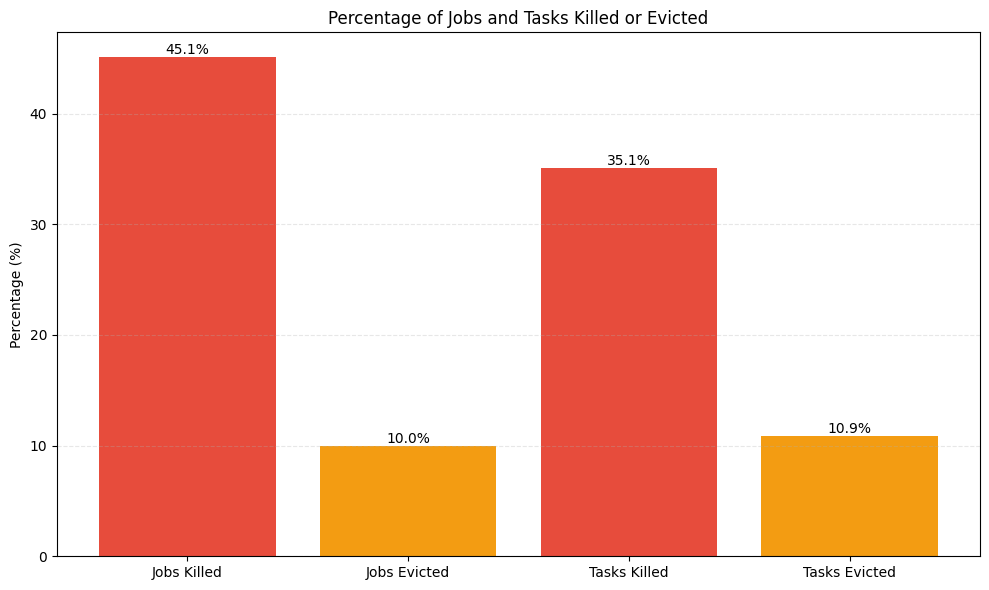

In [122]:
# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Jobs Killed', 'Jobs Evicted', 'Tasks Killed', 'Tasks Evicted']
percentages = [perc_jobs_killed, perc_jobs_evicted, perc_tasks_killed, perc_tasks_evicted]
colors = ['#e74c3c', '#f39c12', '#e74c3c', '#f39c12']

bars = ax.bar(categories, percentages, color=colors)

# labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Jobs and Tasks Killed or Evicted')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# percentage labels 
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentages[i]}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig('images/task5.png', bbox_inches='tight', dpi=300)

Out of all jobs 51% of them were killed or evicted, within these jobs 43% of all tasks were killed or evicted at least once. 

Especially because of these high numbers, the percentage of evictions and kills is highly important. Nearly half of all jobs and tasks experience termination. This is a substantial portion of the workload that doesn't complete successfully on the first attempt and can reflect system reliability indicators. 

The high numbers might reflect the scheduling strategy from Google, as the documentation notes: "it can happen that there are not enough resources to meet all the runtime requests from the tasks, even though each of them is using less than its limit. If this happens, one or more low priority task(s) may be killed." The high number of evictions (83,227 task evictions) demonstrates that lower-priority tasks, which also make up 36% of all jobs and 86% of all tasks, may act as a "buffer" for cluster capacity, being evicted when resources are needed for higher-priority tasks. 

### 6. Do tasks with a low scheduling class have a higher probability of being evicted?

In [123]:
# Visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [124]:
# Filter df for evicted tasks (reusing code from question 5)
df_tasks_evicted = df_task_events.filter(F.col("event_type") == EVICT).select("task_index", "scheduling_class")
df_tasks_evicted.toPandas()

,task_index,scheduling_class
0,101,0
1,118,0
2,1367,0
3,432,0
4,463,1
...,...,...
83222,842,1
83223,772,1
83224,1318,0
83225,76,1


In [125]:
# Group evicted tasks by scheduling class and count them
df_tasks_evicted_count = df_tasks_evicted.groupBy("scheduling_class").count()
df_tasks_evicted_count.toPandas()

,scheduling_class,count
0,1,17086
1,3,873
2,2,3253
3,0,62015


In [126]:
# Calculate percentage
df_tasks_evicted_count.withColumn("percentage", F.round((F.col("count") / tasks_evicted) * 100)).toPandas()

,scheduling_class,count,percentage
0,1,17086,21.0
1,3,873,1.0
2,2,3253,4.0
3,0,62015,75.0


The analysis of 83,227 task evictions show that tasks with a lower scheduling class are evicted more often than tasks with a higher scheduling class. Tasks from class 0 (non-production) make up 75% of all evictions, class 1 21%, class 2 4& and class 3 (most latency-sensitive tasks) only 1%. 

As the  documentation explicitly states "The cluster scheduler attempts to prevent latency-sensitive tasks at these priorities from being evicted due to over-allocation of machine resources."

This explains why class 0 tasks get evicted the most and why higher scheduling classes have some protection against eviction.
The documentation states that EVICT events occur due to: "a higher priority task or job, because the scheduler overcommitted and the actual demand exceeded the machine capacity, because the machine on which it was running became unusable (e.g. taken offline for repairs), or because a disk holding the task's data was lost."

As already assumed in question 5, non-production workloads serve as a resource buffer and get sacrificed to enable the cluster to maintain responsiveness for production workloads.

While Class 0 and 1 dominate evictions by volume, Classes 3-4 still experience eviction rates of 1% to 4%. This indicates that even higher scheduling classes can be evicted under certain conditions (machine failures, extreme resource pressure).

### 7. In general, do tasks from the same job run on the same machine? Comment on the observed locality strategy and its pros and cons.

In [129]:
# Visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


The analysis is filtered to include only jobs with scheduled tasks (event_type = 1) because the question asks whether tasks from the same job run on the same machine, which can only be answered for jobs whose tasks were actually placed on machines.

In [130]:
# Filtering for only scheduled tasks
df_scheduled = df_task_events.filter(F.col("event_type") == 1)

In [131]:
# For each job count number of unique tasks and number of unique machines used

df_jobs_machines = df_scheduled.groupBy("job_ID").agg(
    F.countDistinct("task_index").alias("num_of_tasks"),
    F.countDistinct("machine_ID").alias("num_of_machines")
)

df_jobs_machines.toPandas()

,job_ID,num_of_tasks,num_of_machines
0,6318966074,652,868
1,6319490931,450,437
2,6319448540,250,269
3,6320107735,11,11
4,6320614703,50,50
...,...,...,...
9093,6319687472,1,1
9094,6318647991,1,1
9095,5202600305,1,1
9096,6318393274,1,1


In [134]:
tasks_per_machine = df_jobs_machines.withColumn("tasks_per_machine", F.col("num_of_tasks") / F.col("num_of_machines"))
tasks_per_machine.toPandas()

,job_ID,num_of_tasks,num_of_machines,tasks_per_machine
0,6318966074,652,868,0.751152
1,6319490931,450,437,1.029748
2,6319448540,250,269,0.929368
3,6320107735,11,11,1.000000
4,6320614703,50,50,1.000000
...,...,...,...,...
9093,6319687472,1,1,1.000000
9094,6318647991,1,1,1.000000
9095,5202600305,1,1,1.000000
9096,6318393274,1,1,1.000000


In [136]:
# As some rows contain single-task jobs (num_of_tasks = 1) they will be dropped for the further analysis.

multi_task_jobs = tasks_per_machine.filter(F.col("num_of_tasks") > 1)
multi_task_jobs.toPandas()

,job_ID,num_of_tasks,num_of_machines,tasks_per_machine
0,6318966074,652,868,0.751152
1,6319490931,450,437,1.029748
2,6319448540,250,269,0.929368
3,6320107735,11,11,1.000000
4,6320614703,50,50,1.000000
...,...,...,...,...
2495,6319210990,2,2,1.000000
2496,6319207738,2,2,1.000000
2497,6320000017,2,2,1.000000
2498,6320558712,2,2,1.000000


In [137]:
# Sort list into patterns 
multi_task_jobs = multi_task_jobs.withColumn(
    "category",
    F.when(F.col("tasks_per_machine") > 1, "multiple_tasks_per_machine") # multiple tasks run on a machine
     .when(F.col("tasks_per_machine") == 1, "fully_distributed") # 1 task per machine 
     .when(F.col("tasks_per_machine") < 1, "over_distributed") # more machines than tasks
     .otherwise("?")
)
multi_task_jobs.toPandas()

,job_ID,num_of_tasks,num_of_machines,tasks_per_machine,category
0,6318966074,652,868,0.751152,over_distributed
1,6319490931,450,437,1.029748,multiple_tasks_per_machine
2,6319448540,250,269,0.929368,over_distributed
3,6320107735,11,11,1.000000,fully_distributed
4,6320614703,50,50,1.000000,fully_distributed
...,...,...,...,...,...
2495,6319210990,2,2,1.000000,fully_distributed
2496,6319207738,2,2,1.000000,fully_distributed
2497,6320000017,2,2,1.000000,fully_distributed
2498,6320558712,2,2,1.000000,fully_distributed


In [138]:
category_counts = multi_task_jobs.groupBy("category").agg(F.count("*").alias("num_of_tasks"))
category_counts.toPandas()

,category,num_of_tasks
0,over_distributed,507
1,multiple_tasks_per_machine,151
2,fully_distributed,1842


In [139]:
# This is counting the unique jobs in the task_events table, this number differs from the unique jobs from job_events
total_scheduled__multit_jobs = multi_task_jobs.select("job_id").distinct().count()
total_scheduled__multit_jobs

2500

Analysis based on 2500 multi-task jobs that had at least one task scheduled (event_type=1) in the task_events table.

In [141]:
# To verify the number of total_scheduled_multitjobs, this line checks the unique jobs in df_jobs_scheduled
# which is the dataframe of task_events with event_type = 1 
# additionally we count the single-task jobs
total_scheduled_jobs = df_scheduled.select("job_id").distinct().count()
total_scheduled_singlet_jobs = tasks_per_machine.filter(F.col("num_of_tasks") == 1).select("job_id").distinct().count()

In [142]:
total_scheduled_jobs

9098

In [143]:
total_scheduled_singlet_jobs

6598

In [144]:
# manually verifying the total multi job count from category_counts table
507 + 151 + 1842

2500

In [145]:
# manually varifying the total of jobs
6598 + 2500 

9098

In [146]:
# Calculate percentage
category_counts.withColumn("percentage", F.round((F.col("num_of_tasks") / total_scheduled__multit_jobs) * 100)).toPandas()

,category,num_of_tasks,percentage
0,over_distributed,507,20.0
1,multiple_tasks_per_machine,151,6.0
2,fully_distributed,1842,74.0


Tasks from the same job generally do not run on the same machine. Google employs a distributed scheduling strategy where tasks are spread across different machines. The analysis based on 2,500 multi-task jobs shows that only 6% have multiple tasks sharing machines. Google seems to avoid placing tasks from the same job on the same machine. Nearly 74% of jobs have a 1:1 task-to-machine mapping, with each task running on a distinct machine. This is the dominant scheduling pattern. 20% are over-distributed meaning that these jobs used more machines than they had tasks. 

One advantage of this high distribution scheduling system is, that a potential machine failure affects only one task per job for the majority of jobs. Scalability gets a lot easier with this scheduling as well, as no job is limited by any single machine's capacity. Distributing tasks across machines also prevents a single machine from becoming overloaded while others remain underutilized. One disadvantage is the high complexity and the communication and coordination demand for the scheduler. 

### 8. Are the tasks that request the more resources the one that consume the more resources?

In [148]:
task_usage_schema = StructType([
    StructField("start_time", LongType(), True),
    StructField("end_time", LongType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("mean_cpu_usage", DoubleType(), True),
    StructField("canonical_memory_usage", DoubleType(), True),
    StructField("assigned_memory_usage", DoubleType(), True),
    StructField("unmapped_page_cache", DoubleType(), True),
    StructField("total_page_cache", DoubleType(), True),
    StructField("max_memory_usage", DoubleType(), True),
    StructField("mean_disk_io_time", DoubleType(), True),
    StructField("mean_local_disk_space", DoubleType(), True),
    StructField("max_cpu_usage", DoubleType(), True),
    StructField("max_disk_io_time", DoubleType(), True),
    StructField("cpi", DoubleType(), True),
    StructField("mai", DoubleType(), True),
    StructField("sample_portion", DoubleType(), True),
    StructField("aggregation_type", IntegerType(), True),
    StructField("sampled_cpu_usage", DoubleType(), True),
])

In [149]:
df_task_usage = ss.read.csv(os.path.join(DATA_DIR,"task_usage/*.csv.gz"), schema=task_usage_schema)
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037


In [150]:
# Filtering to see an example where usage is zero
df_task_usage.filter(F.col("mean_cpu_usage")==0.0).limit(1).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767315000000,767317000000,4857081234,87,778700158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974,0.008457,0.0,0,0.0


In [151]:
# Check df_task_events
df_task_events.limit(3).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None


 We will compare:
- req_cpu_cores <-> mean_cpu_usage
- req_ram <-> cannonical_memory_usage
- req_local_disk <-> mean_local_disk_space

So, we should take out only what we need

In [168]:
# Here, we check if there are tasks that can have changed their resource requests (CPU, RAM, or Disk), having more than one distinct request
df_task_events.groupBy("job_id", "task_index").agg(
        F.countDistinct("req_cpu_cores").alias("distinct_cpu"),
        F.countDistinct("req_ram").alias("distinct_ram"),
        F.countDistinct("req_local_disk").alias("distinct_disk")
    ) .filter((F.col("distinct_cpu") > 1) | (F.col("distinct_ram") > 1) | (F.col("distinct_disk") > 1)).show()

[Stage 862:============================>                            (1 + 1) / 2]

+----------+----------+------------+------------+-------------+
|    job_id|task_index|distinct_cpu|distinct_ram|distinct_disk|
+----------+----------+------------+------------+-------------+
|6253061949|         2|           1|           2|            1|
|6226100490|         0|           2|           2|            1|
|6252955795|         0|           1|           1|            2|
|6252955795|         1|           1|           1|            2|
|6253061949|         0|           1|           2|            1|
|6253061949|         1|           1|           2|            1|
|6252955579|         0|           1|           2|            1|
+----------+----------+------------+------------+-------------+



We see that in total, there are only 7 such tasks, which, compared to huge number of total tasks, can be ignored for the purpuse of our analysis!

Now, we have to normalize mean_cpu_usage, because the document provided stated that this column is not normalized. Additionaly, we  want to check if other columns should be normalized, and normalize them if necessary

In [175]:
relevant_cols = ["mean_cpu_usage", "canonical_memory_usage",  "mean_local_disk_space"]

In [176]:
def is_normalized(df, column_name):
    stats = df.select(
        F.min(F.col(column_name)).alias("min_val"),
        F.max(F.col(column_name)).alias("max_val")
    ).collect()[0]
    
    is_norm = stats["min_val"] >= 0 and stats["max_val"] <= 1
    return is_norm
    
def normalize(df, col_name):
    max_val = df.agg(F.max(col_name)).collect()[0][0]
    if max_val == 0:
        return df
    return df.withColumn(col_name, F.col(col_name) / max_val)


for col_name in relevant_cols:
    is_norm = is_normalized(df_task_usage, col_name)
    print(f"{col_name} is normalized: {is_norm}")
    if not is_norm:
        normalize(df_task_usage, col_name)

mean_cpu_usage is normalized: False


canonical_memory_usage is normalized: True


[Stage 901:=============================================>           (4 + 1) / 5]

mean_local_disk_space is normalized: True


In [179]:
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037


In [180]:
# Now, for each specific task and job, we calculate average mean resources, across different timeframes
df_usage_agg = df_task_usage.groupBy("job_id", "task_index").agg(
    F.mean("mean_cpu_usage").alias("avg_cpu_usage"),
    F.mean("canonical_memory_usage").alias("avg_mem_usage"),
    F.mean("mean_local_disk_space").alias("avg_disk_usage")
)

df_req_agg = df_task_events.groupBy("job_id", "task_index").agg(
    F.max("req_cpu_cores").alias("req_cpu_cores"),
    F.max("req_ram").alias("req_ram"),
    F.max("req_local_disk").alias("req_local_disk")
)

In [181]:
df_joined = df_usage_agg.join(df_req_agg, ["job_id", "task_index"])
df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk
0,17109330,156,0.042698,0.007924,0.000100,0.06250,0.01398,0.000672
1,28185708,9,0.000739,0.004550,0.000000,0.01562,0.00795,0.000011
2,331416465,79,0.054867,0.013820,0.000071,0.13130,0.02057,0.000139


In [182]:
df_joined.select("job_id", "task_index").distinct().count()

301506

In order to determine if tasks that request more resources actually use them, we will calculate usage_efficiency for all three types of resources. This score is basically the percentage of requested resources that is actually used. We calculate that as: $$usage\_efficiency = \frac{actual\_usage}{requested\_amount}$$

In [184]:
def safe_divide(numerator_col, denominator_col):
    return F.when(F.col(denominator_col) > 0, F.col(numerator_col) / F.col(denominator_col)).otherwise(0)

df_joined = df_joined.withColumn("cpu_efficiency", safe_divide("avg_cpu_usage", "req_cpu_cores"))
df_joined = df_joined.withColumn("ram_efficiency", safe_divide("avg_mem_usage", "req_ram"))
df_joined = df_joined.withColumn("disk_efficiency", safe_divide("avg_disk_usage", "req_local_disk"))

df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk,cpu_efficiency,ram_efficiency,disk_efficiency
0,17109330,156,0.042698,0.007924,0.000100,0.06250,0.01398,0.000672,0.683161,0.566829,0.149234
1,28185708,9,0.000739,0.004550,0.000000,0.01562,0.00795,0.000011,0.047301,0.572381,0.000000
2,331416465,79,0.054867,0.013820,0.000071,0.13130,0.02057,0.000139,0.417873,0.671870,0.511614


Now, we came to an idea. If the relationship between efficiencies and requests is linear, that means that larger tasks do generally use more resources that they requested. In order to check that, we will calculate correlation between those two, for each resource

In [187]:
correlation_cpu = df_joined.stat.corr("req_cpu_cores", "cpu_efficiency")
correlation_ram = df_joined.stat.corr("req_ram", "ram_efficiency")
correlation_disk = df_joined.stat.corr("req_local_disk", "disk_efficiency")

print(f"CPU Linear Correlation: {correlation_cpu}")
print(f"RAM Linear Correlation: {correlation_ram}")
print(f"Disk Linear Correlation: {correlation_disk}")

[Stage 957:>                                                        (0 + 2) / 2]

CPU Linear Correlation: -0.17251780655481613
RAM Linear Correlation: -0.01709336199847316
Disk Linear Correlation: -0.054217459657060055


Here, we see that CPU, RAM, and Disk correlations are very close to zero, which means no linear correlation! Therefore, it doesn't mean that tasks that require more resources actually use them effectively. However, the correlation coefficient might have missed some other types of relationships, so now, we plot these variables to check potential non-linear trends or patterns between eficiencies and requests.

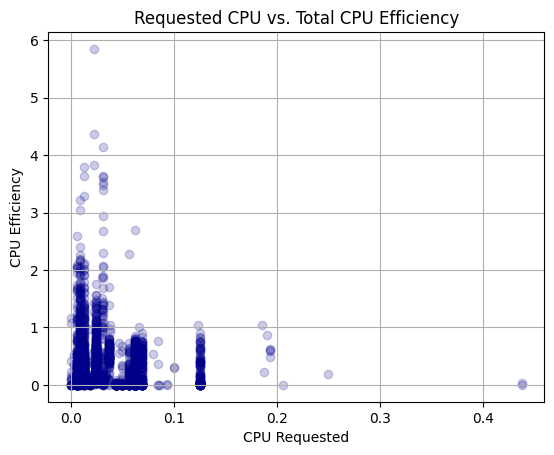

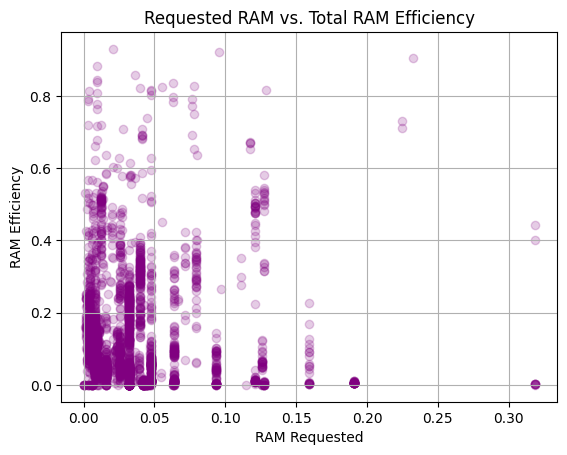

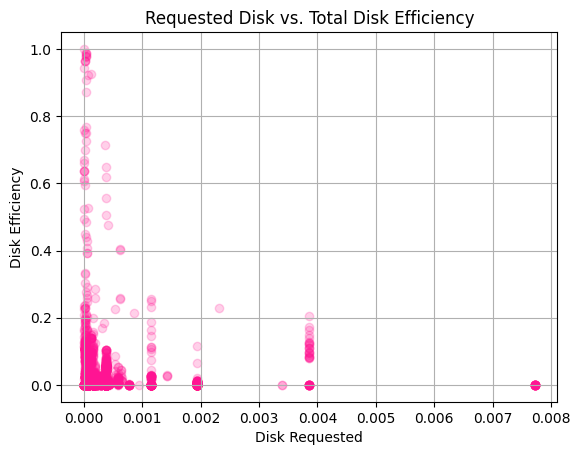

In [192]:
# sample 1% of the data
df_sample = df_joined.select("req_cpu_cores", "cpu_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_cpu_cores"], df_sample["cpu_efficiency"], alpha=0.2, color='darkblue')
plt.title("Requested CPU vs. Total CPU Efficiency")
plt.xlabel("CPU Requested")
plt.ylabel("CPU Efficiency")
plt.grid(True)
plt.savefig('images/task8-1.png', bbox_inches='tight', dpi=300)
plt.show()

df_sample = df_joined.select("req_ram", "ram_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_ram"], df_sample["ram_efficiency"], alpha=0.2, color='purple')
plt.title("Requested RAM vs. Total RAM Efficiency")
plt.xlabel("RAM Requested")
plt.ylabel("RAM Efficiency")
plt.grid(True)
plt.savefig('images/task8-2.png', bbox_inches='tight', dpi=300)
plt.show()

df_sample = df_joined.select("req_local_disk", "disk_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_local_disk"], df_sample["disk_efficiency"], alpha=0.2, color='deeppink')
plt.title("Requested Disk vs. Total Disk Efficiency")
plt.xlabel("Disk Requested")
plt.ylabel("Disk Efficiency")
plt.grid(True)
plt.savefig('images/task8-3.png', bbox_inches='tight', dpi=300)
plt.show()

**Conclusion**: Finally, we conclude that in general, tasks that require more resources don't use them so efficiently. All plots show that as the requested amount increases, the efficiency either stays flat or actually decreases.

### 9. Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

In [200]:
# Visual check of df
df_task_events.limit(3).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None


In [194]:
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037


In [195]:
# We filter the task events table to get only evictions (event type 2)
# Then, we group these events into 5 minute windows to count how many evictions occurred per machine in each timeframe

# 5 minutes = 300000000 ms
window_val = 300000000

df_evict_agg = df_task_events.filter(F.col("event_type") == 2).withColumn("window", (F.col("timestamp") / window_val) \
                             .cast("long")).groupBy("machine_id", "window").agg(F.count("*").alias("eviction_count"))

df_evict_agg.limit(3).toPandas()

,machine_id,window,eviction_count
0,257388826,2560,2
1,3231138163,2560,1
2,2197523778,2561,3


In [196]:
# We do the same grouping in 5 minute windows, on task usage table
df_usage_peaks = df_task_usage.withColumn("window", (F.col("start_time") / window_val).cast("long")) \
                              .groupBy("machine_id", "window") \
                              .agg( F.max("mean_cpu_usage").alias("peak_cpu"), F.max("canonical_memory_usage").alias("peak_mem"))

df_usage_peaks.limit(3).toPandas()

,machine_id,window,peak_cpu,peak_mem
0,4873175358,2557,0.14160,0.13330
1,336030391,2557,0.08301,0.08032
2,430388230,2557,0.25000,0.13400


In [197]:
# Then we join the two tables in order for a machine and window to match
df_correlation = df_evict_agg.join(df_usage_peaks, ["machine_id", "window"], "left")
df_correlation.limit(3).toPandas()

,machine_id,window,eviction_count,peak_cpu,peak_mem
0,257388826,2560,2,0.27290,0.16770
1,2197523778,2561,3,0.18630,0.06824
2,3231138163,2560,1,0.06372,0.13310


In [199]:
# Now we calculate correlations between peaks of high resource consumption (both cpu and mem) with eviction_count:
cpu_corr = df_correlation.stat.corr("peak_cpu", "eviction_count")
mem_corr = df_correlation.stat.corr("peak_mem", "eviction_count")

print(f"Correlation (CPU Peak vs Evictions): {cpu_corr}")
print(f"Correlation (RAM Peak vs Evictions): {mem_corr}")

[Stage 1072:============================>                           (1 + 1) / 2]

Correlation (CPU Peak vs Evictions): -0.025808226132559745
Correlation (RAM Peak vs Evictions): -0.028798712910271602


**Conclusion:** We conclude correlation is low, which means that resource peaks are not the main reason for evictions

### 10. How often does it happen that the resources of a machine are over-committed?

In [12]:
# Visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [201]:
# Visual check of df
df_machines.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [202]:
# Visual check of df
df_task_usage.limit(5).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037
3,767314000000,767329000000,6219557576,26,3725143539,0.000140,0.00000,0.00000,0.000000,0.000000,0.00000,0.000057,0.000000,0.002106,0.000571,3.957,0.012100,0.0,0,0.000000
4,767314000000,767400000000,6302814662,148,1094423,0.080200,0.04437,0.04572,0.000122,0.000198,0.04565,0.002686,0.000024,0.164300,0.032840,1.976,0.004033,0.0,0,0.011490


In [203]:
# Task schedule events 
task_schedule = df_task_events.filter(
    F.col("event_type") == 1  # SCHEDULE events
).select(
    "job_id",
    "task_index", 
    "machine_id",
    "timestamp",
    "req_cpu_cores",
    "req_ram"
).withColumnRenamed("timestamp", "schedule_time")

task_schedule.limit(5).toPandas()

,job_id,task_index,machine_id,schedule_time,req_cpu_cores,req_ram
0,515042969,15,257406228,767314028182,0.015620,0.015530
1,515042969,14,1436371121,767315019366,0.015620,0.015530
2,6282133822,435,257347123,767315396801,0.093750,0.206800
3,515042969,3,9837664,767316288691,0.015620,0.015530
4,6316259781,1367,3383067123,767317214817,0.009369,0.005486


In [204]:
# Task finish/evict/fail/kill times
task_end = df_task_events.filter(
    F.col("event_type").isin([2, 3, 4, 5])  # EVICT, FAIL, FINISH, KILL
).select(
    "job_id",
    "task_index",
    "machine_id",
    "timestamp"
).withColumnRenamed("timestamp", "end_time")


task_end.limit(5).toPandas()

,job_id,task_index,machine_id,end_time
0,6319230508,13,6567628.0,767314057755
1,6319230508,3,902367.0,767314057799
2,515042969,3,NaN,767314057847
3,6319230508,1,277449078.0,767314057882
4,6319230508,2,1275580.0,767315396683


In [208]:
# Join schedule with end times to get task execution windows
task_windows = task_schedule.join(
    task_end,
    ["job_id", "task_index", "machine_id"],
    "left"
).select(
    "job_id",
    "task_index",
    "machine_id",
    "schedule_time",
    "end_time",
    "req_cpu_cores",
    "req_ram"
)

task_windows.limit(5).toPandas()

,job_id,task_index,machine_id,schedule_time,end_time,req_cpu_cores,req_ram
0,515042969,15,257406228,767314028182,NaN,0.015620,0.015530
1,515042969,14,1436371121,767315019366,NaN,0.015620,0.015530
2,6282133822,435,257347123,767315396801,NaN,0.093750,0.206800
3,515042969,3,9837664,767316288691,NaN,0.015620,0.015530
4,6316259781,1367,3383067123,767317214817,7.768194e+11,0.009369,0.005486


In [209]:
# For tasks without end time (NaNs)
max_timestamp = df_task_events.agg(F.max("timestamp")).collect()[0][0]
min_timestamp = df_task_events.agg(F.min("timestamp")).collect()[0][0]

task_windows = task_windows.withColumn(
    "end_time",
    F.when(
        F.col("end_time").isNull() | (F.col("end_time") <= F.col("schedule_time")),
        F.lit(max_timestamp)
    ).otherwise(F.col("end_time"))
)
task_windows.limit(5).toPandas()

,job_id,task_index,machine_id,schedule_time,end_time,req_cpu_cores,req_ram
0,515042969,15,257406228,767314028182,777335318056,0.015620,0.015530
1,515042969,14,1436371121,767315019366,777335318056,0.015620,0.015530
2,6282133822,435,257347123,767315396801,777335318056,0.093750,0.206800
3,515042969,3,9837664,767316288691,777335318056,0.015620,0.015530
4,6316259781,1367,3383067123,767317214817,776819437630,0.009369,0.005486


In [210]:
# Sample checkpoints every 5 minutes 
checkpoint_interval = 300 * 1000000  

checkpoints = ss.range(
    min_timestamp, 
    max_timestamp + checkpoint_interval, 
    checkpoint_interval
).toDF("timestamp")

checkpoints.count()

85

In [211]:
# For each checkpoint find all tasks running on each machine
running_tasks = checkpoints.join(
    task_windows,
    (checkpoints.timestamp >= task_windows.schedule_time) &
    (checkpoints.timestamp < task_windows.end_time)
)

running_tasks.count()

3661701

In [212]:
# Aggregate resource reqs per machine at each checkpoint
machine_load = running_tasks.groupBy("timestamp", "machine_id").agg(
    F.sum("req_cpu_cores").alias("total_cpu_requested"),
    F.sum("req_ram").alias("total_memory_requested"),
    F.count("*").alias("num_tasks")
)

machine_load.count()

760911

In [213]:
machine_load.limit(5).toPandas()

,timestamp,machine_id,total_cpu_requested,total_memory_requested,num_tasks
0,776580561217,1436371121,0.540560,0.358910,15
1,767880561217,1734526,0.306210,0.318278,14
2,771780561217,4304147912,103.956865,129.564650,834
3,770880561217,4820390100,0.160399,0.150830,11
4,774180561217,1227286783,0.618675,0.734903,27


In [214]:
# Machine capacity at each checkpoint from capacity updates (ADD / UPDATE)
machine_capacity_events = df_machines.filter(
    F.col("event_type").isin([0, 2])  
).select(
    F.col("timestamp").alias("capacity_timestamp"),
    F.col("machine_ID").alias("machine_id"),
    "CPUs",
    "memory_capacity"
)

machine_capacity_events.limit(5).toPandas()

,capacity_timestamp,machine_id,CPUs,memory_capacity
0,0,5,0.5,0.2493
1,0,6,0.5,0.2493
2,0,7,0.5,0.2493
3,0,10,0.5,0.2493
4,0,13,0.5,0.2493


In [215]:
# Use window function to find the next capacity update time for each machine
capacity_window = Window.partitionBy("machine_id").orderBy("capacity_timestamp")

machine_capacity = machine_capacity_events.withColumn(
    "next_update",
    F.lead("capacity_timestamp").over(capacity_window)
)

machine_capacity.limit(5).toPandas()

,capacity_timestamp,machine_id,CPUs,memory_capacity,next_update
0,0,5,0.5,0.2493,8.361249e+11
1,836124903464,5,0.5,0.2493,NaN
2,0,6,0.5,0.2493,NaN
3,0,7,0.5,0.2493,NaN
4,0,10,0.5,0.2493,1.307163e+12


In [216]:
# For each checkpoint, get the most recent machine capacity
comparison = machine_load.join(
    machine_capacity,
    (machine_load.machine_id == machine_capacity.machine_id) &
    (machine_load.timestamp >= machine_capacity.capacity_timestamp) &
    (
        (machine_capacity.next_update.isNull()) | 
        (machine_load.timestamp < machine_capacity.next_update)
    ),
    "inner"
).select(
    machine_load.timestamp,
    machine_load.machine_id,
    "total_cpu_requested",
    "total_memory_requested",
    "num_tasks",
    "CPUs",
    "memory_capacity"
)

comparison.limit(5).toPandas()

,timestamp,machine_id,total_cpu_requested,total_memory_requested,num_tasks,CPUs,memory_capacity
0,776580561217,1436371121,0.540560,0.358910,15,0.5,0.2493
1,767880561217,1734526,0.306210,0.318278,14,0.5,0.4995
2,771780561217,4304147912,103.956865,129.564650,834,0.5,0.4995
3,770880561217,4820390100,0.160399,0.150830,11,1.0,1.0000
4,774180561217,1227286783,0.618675,0.734903,27,0.5,0.4995


In [217]:
overcommitted = comparison.withColumn(
    "cpu_overcommitted",
    (F.col("total_cpu_requested") > F.col("CPUs")).cast("int")
).withColumn(
    "memory_overcommitted",
    (F.col("total_memory_requested") > F.col("memory_capacity")).cast("int")
).withColumn(
    "any_overcommitted",
    (
        (F.col("total_cpu_requested") > F.col("CPUs")) |
        (F.col("total_memory_requested") > F.col("memory_capacity"))
    ).cast("int")
).withColumn(
    "both_overcommitted",
    (
        (F.col("total_cpu_requested") > F.col("CPUs")) &
        (F.col("total_memory_requested") > F.col("memory_capacity"))
    ).cast("int")
)
overcommitted.limit(10).toPandas()

,timestamp,machine_id,total_cpu_requested,total_memory_requested,num_tasks,CPUs,memory_capacity,cpu_overcommitted,memory_overcommitted,any_overcommitted,both_overcommitted
0,776580561217,1436371121,0.540560,0.358910,15,0.5,0.2493,1,1,1,1
1,767880561217,1734526,0.306210,0.318278,14,0.5,0.4995,0,0,0,0
2,771780561217,4304147912,103.956865,129.564650,834,0.5,0.4995,1,1,1,1
3,770880561217,4820390100,0.160399,0.150830,11,1.0,1.0000,0,0,0,0
4,774180561217,1227286783,0.618675,0.734903,27,0.5,0.4995,1,1,1,1
5,770580561217,6566544,0.441559,0.410716,29,0.5,0.2493,0,1,1,0
6,776280561217,4802131154,23.547485,27.589793,192,1.0,1.0000,1,1,1,1
7,775380561217,8055709,0.431210,0.397360,16,0.5,0.4995,0,0,0,0
8,776580561217,1436368677,0.443750,0.263730,10,0.5,0.4995,0,0,0,0
9,773580561217,4142759100,0.687057,0.745290,22,0.5,0.4995,1,1,1,1


In [218]:
total_measurements = comparison.count()
cpu_overcommit = overcommitted.filter(F.col("cpu_overcommitted") == 1).count()
mem_overcommit = overcommitted.filter(F.col("memory_overcommitted") == 1).count()
any_overcommit = overcommitted.filter(F.col("any_overcommitted") == 1).count()
both_overcommit = overcommitted.filter(F.col("both_overcommitted") == 1).count()

In [219]:
print(f"Total measurements: {total_measurements:,}")
print(f"\nCPU overcommitted: {cpu_overcommit:,} ({cpu_overcommit/total_measurements*100:.4f}%)")
print(f"Memory overcommitted: {mem_overcommit:,} ({mem_overcommit/total_measurements*100:.4f}%)")
print(f"Any resource overcommitted: {any_overcommit:,} ({any_overcommit/total_measurements*100:.4f}%)")
print(f"Both resources overcommitted: {both_overcommit:,} ({both_overcommit/total_measurements*100:.4f}%)")

Total measurements: 760,911

CPU overcommitted: 60,491 (7.9498%)
Memory overcommitted: 64,162 (8.4323%)
Any resource overcommitted: 73,727 (9.6893%)
Both resources overcommitted: 50,926 (6.6928%)


760,911 machine-time period measurements were analysed by joining task_usage data with task_events to get resource requests for each running task and aggregating the total requested resources per machine per time period (in 5-minute windows). For  each period the machine capacity was matched with the total requested resources. The result compares the total requested resources against available capacity.

**Conclusion:** As a result it can be said, that machine resources are overcommitted approximately 9.68% of the time. Specifically CPU is overcommitted 7.94% of the time and memory is overcommitted 8.43% of the time. Both of them are overcommitted at the same time in 6.69% of the time.

### 11. Original question 1 - What is the distribution of priority levels within scheduling class 3, and do higher priorities within this class correlate with lower eviction/kill rates?

In [222]:
# Display priorities in dataframe task_events
df_priorities = df_task_events.select("priority").groupBy("priority").count().sort("priority")
df_priorities.toPandas()

,priority,count
0,0,537475
1,1,87322
2,2,4127
3,3,42
4,4,569041
5,6,5145
6,7,30
7,8,12507
8,9,35225
9,10,400


As the documentation states, 0 is the lowest priority (least important) and "tasks with larger priority numbers generally get preference for resources over tasks with smaller priority numbers". The documentation disctictions between "free" (low priority), "production" and "monitoring" priorities. 

The documentation does not say from which specific priority class a task is considered as "free" or "production" priority. Looking at the numbers, class 0 most probably represents the "free" priority tasks, while priority 4 (class with the most tasks) likely falls within the "production" priority range, representing latency-sensitive tasks that the scheduler might protects from eviction. 

In [223]:
# Display priorities in dataframe task_events grouped by scheduling_class
df_priorities_sclass = df_task_events.select("priority", "scheduling_class").groupBy("scheduling_class", "priority").agg(
    F.count("*").alias("count")).orderBy("scheduling_class", "priority")
df_priorities_sclass.toPandas()

,scheduling_class,priority,count
0,0,0,341467
1,0,1,69844
2,0,2,317
3,0,4,552429
4,0,6,3587
5,0,8,7018
6,0,9,2828
7,0,10,3
8,1,0,119281
9,1,1,2044


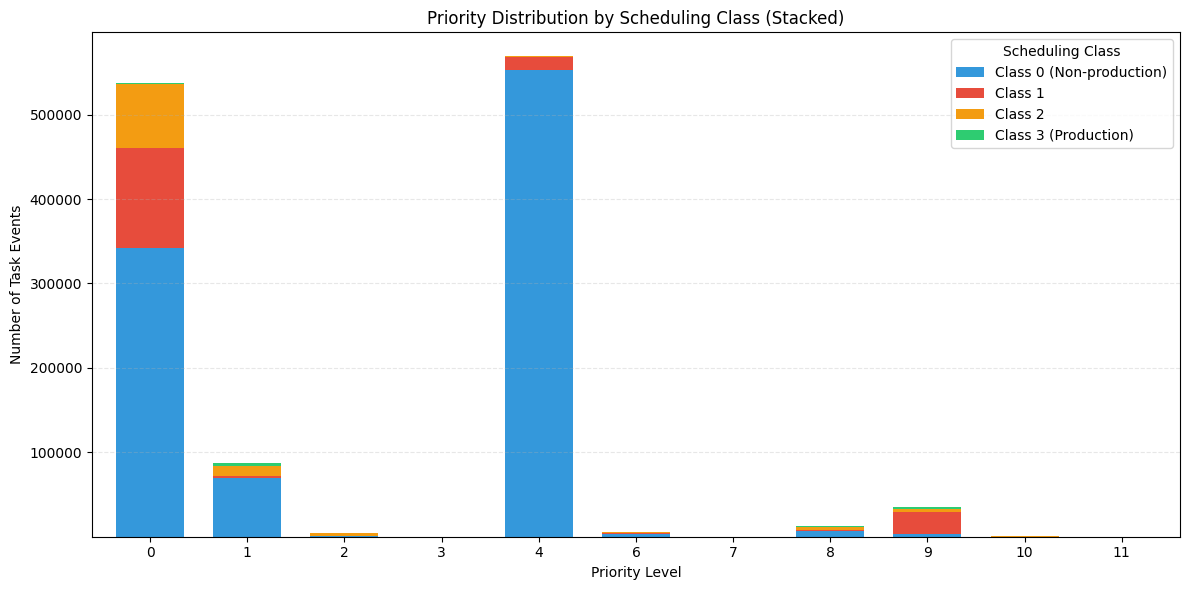

In [224]:
df_priorities_pd = df_priorities_sclass.toPandas()

# pivot the data to get priorities as rows and scheduling classes as columns
pivot_data = df_priorities_pd.pivot(index='priority', columns='scheduling_class', values='count').fillna(0)

# create chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
pivot_data.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

# Labels and title
ax.set_xlabel('Priority Level')
ax.set_ylabel('Number of Task Events')
ax.set_title('Priority Distribution by Scheduling Class (Stacked)')
ax.set_xticklabels(pivot_data.index, rotation=0)
ax.legend(title='Scheduling Class', labels=['Class 0 (Non-production)', 'Class 1', 'Class 2', 'Class 3 (Production)'])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('images/task11-1.png', bbox_inches='tight', dpi=300)

In [225]:
# Filter for scheduling class 3 only
df_class3_priorities = df_priorities_sclass.filter(F.col("scheduling_class") == 3).distinct()
df_class3_priorities.toPandas()

,scheduling_class,priority,count
0,3,0,1245
1,3,1,3845
2,3,2,15
3,3,8,917
4,3,9,2630
5,3,10,39


In [226]:
# Varify with df_task_events
df_class3_priorities = df_task_events.filter(F.col("scheduling_class") == 3).groupBy("priority").count().orderBy("priority")
df_class3_priorities.toPandas()

,priority,count
0,0,1245
1,1,3845
2,2,15
3,8,917
4,9,2630
5,10,39


In [227]:
# Calculate total tasks in class 3
total_class3_tasks = df_task_events.filter(F.col("scheduling_class") == 3).count()
total_class3_tasks

8691

In [228]:
# manual check total_class3_tasks
1245 + 3845 + 15 + 917 + 2630 + 39

8691

In [229]:
# Percentages
df_class3_priorities_perc = df_class3_priorities.withColumn("percentage", F.round((F.col("count") / total_class3_tasks) * 100, 1)
).orderBy("priority")
df_class3_priorities_perc.toPandas()

,priority,count,percentage
0,0,1245,14.3
1,1,3845,44.2
2,2,15,0.2
3,8,917,10.6
4,9,2630,30.3
5,10,39,0.4


In [230]:
# For each priority in class 3, count evictions and kills
df_class3_evict_kill = df_task_events.filter(F.col("scheduling_class") == 3).groupBy("priority").agg(
    F.count("*").alias("total_events"),
    F.sum(F.when(F.col("event_type") == EVICT, 1).otherwise(0)).alias("evictions"),
    F.sum(F.when(F.col("event_type") == KILL, 1).otherwise(0)).alias("kills")
).orderBy("priority")
df_class3_evict_kill.toPandas()

,priority,total_events,evictions,kills
0,0,1245,181,194
1,1,3845,647,244
2,2,15,0,3
3,8,917,0,494
4,9,2630,44,677
5,10,39,1,2


In [231]:
# Calculate eviction and kill rates per priority
df_class3_rates = df_class3_evict_kill.withColumn(
    "eviction_rate", 
    F.round((F.col("evictions") / F.col("total_events")) * 100, 2)
).withColumn(
    "kill_rate",
    F.round((F.col("kills") / F.col("total_events")) * 100, 2)
).orderBy("priority")
df_class3_rates.toPandas()

,priority,total_events,evictions,kills,eviction_rate,kill_rate
0,0,1245,181,194,14.54,15.58
1,1,3845,647,244,16.83,6.35
2,2,15,0,3,0.00,20.00
3,8,917,0,494,0.00,53.87
4,9,2630,44,677,1.67,25.74
5,10,39,1,2,2.56,5.13


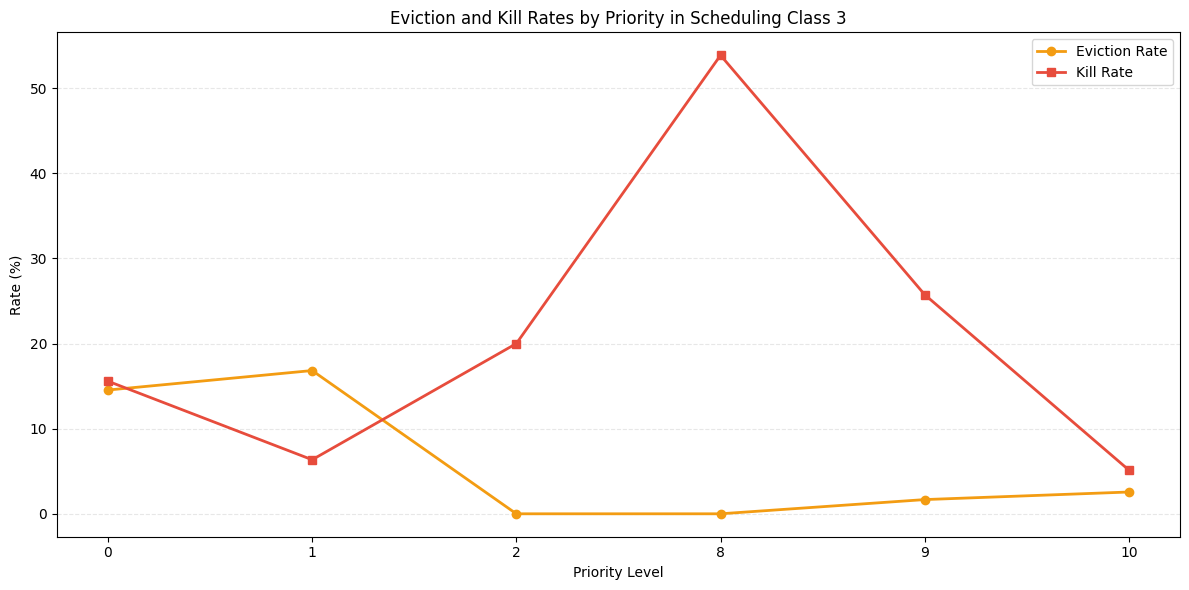

In [232]:
df_plot = df_class3_rates.orderBy("priority").toPandas()

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = range(len(df_plot))
priorities = df_plot['priority'].tolist()

ax.plot(x_pos, df_plot['eviction_rate'], marker='o', label='Eviction Rate', color='#f39c12', linewidth=2)
ax.plot(x_pos, df_plot['kill_rate'], marker='s', label='Kill Rate', color='#e74c3c', linewidth=2)
ax.set_xlabel('Priority Level')
ax.set_ylabel('Rate (%)')
ax.set_title('Eviction and Kill Rates by Priority in Scheduling Class 3')
ax.set_xticks(x_pos)
ax.set_xticklabels(priorities)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('images/task11-2.png', bbox_inches='tight', dpi=300)

In scheduling class 3 (latency-sensitive production tasks) priority 1 task dominate with 44%, followed by priority 9 at 30% and priority 0 at 14%. Priority 8 makes up 10%, while priorities 2 and 10 are minimal at 0.2% and 0.4%. This suggests that within the most latency-sensitive scheduling class, tasks still operate at varying priority levels, though most tasks (75%) are labelled priority 1 or 9.

Surprisingly, higher priorities do not consistently correlate with lower eviction and kill rates within scheduling class 3. The data reveals counterintuitive patterns. Priority 8 experiences the highest kill rate at 53%, despite being a relatively high priority level. This is unexpected and suggests that priority 8 tasks may be frequently killed for reasons unrelated to resource competition (such as user cancellation, job dependencies, or task failures). Priority 10, the highest priority level in this class, does show the lowest disruption rates, which aligns with expectations that the scheduler would protect the highest-priority tasks.

Eviction rates are more clearly correlated with priority than kill rates. Higher priorities (8, 9, 10) show near-zero eviction rates (0-3%), while lower priorities (0, 1) experience slightly higher eviction rates (14-17%). This suggests the scheduler is successfully protecting high-priority tasks from resource-based evictions. Kill rates do not follow this pattern, as kills are also triggered by factors beyond the scheduler's control (e.g. human actions).

### 12. Original question 2 - Are high-priority tasks evenly distributed across all machines, or are they concentrated on a few specific machines?

In [239]:
# Take tasks where priority is greater than N
N = 8
# we choose to percieve high priority tasks as the ones with priority larger than 8

df_high_priorities = df_task_events.select("job_id", "task_index", "machine_id", "priority").filter(F.col("priority") > N)
df_high_priorities.limit(3).toPandas()

,job_id,task_index,machine_id,priority
0,6282133822,435,257347123.0,9
1,6256516525,30,6566931.0,10
2,6256516525,30,NaN,10


In [240]:
df_high_priorities.select("machine_id").distinct().count()

5966

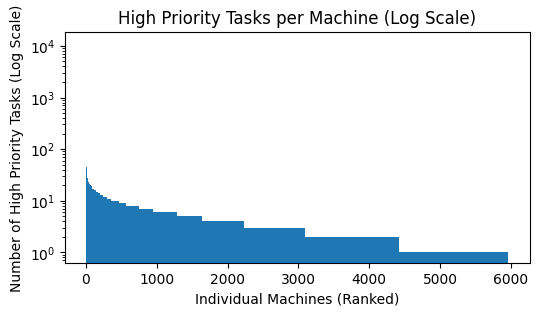

In [242]:
machine_counts = df_high_priorities.groupBy("machine_id").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(6, 3))
plt.bar(range(len(machine_counts)), machine_counts['count'], width=1.0)
plt.yscale('log') # This is the magic line
plt.xlabel("Individual Machines (Ranked)")
plt.ylabel("Number of High Priority Tasks (Log Scale)")
plt.title("High Priority Tasks per Machine (Log Scale)")
plt.savefig('images/high_priority_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

In [243]:
machine_counts

,machine_id,count
0,NaN,11805
1,4.304148e+09,123
2,1.273561e+06,86
3,6.201460e+09,65
4,2.847579e+08,65
...,...,...
5961,4.875410e+05,1
5962,2.198019e+09,1
5963,2.948472e+08,1
5964,7.109490e+05,1


We analyzed how high-priority tasks (Priority 8+) are distributed across the cluster by counting the number of tasks executed per machine.

**Conclusion**: Our data shows that important tasks are packed together. A very small group of machines handles almost all the important work (about 12,000 tasks each). Meanwhile, thousands of other machines handle almost zero important tasks. We used log scale for visualization, because otherwise, the machines with only a few tasks would look like zero on the graph.